In [17]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier

In [18]:
file_path = './dataset/'
train_fn = 'FordA_TRAIN.arff'
test_fn = 'FordA_TEST.arff'

def read_ariff(path):
    raw_data, meta = loadarff(path)
    cols = [x for x in meta]
    data2d = np.zeros([raw_data.shape[0], len(cols)])

    for i, col in zip(range(len(cols)), cols):
        data2d[:, i]=raw_data[col]
    return data2d

train =  read_ariff(file_path + train_fn)
test = read_ariff(file_path + test_fn)

In [19]:
print('train_set.shape:', train.shape)
print('test_set.shape:', test.shape)

train_set.shape: (3601, 501)
test_set.shape: (1320, 501)


In [20]:
x_train_temp = train[:,:-1]
y_train_temp = train[:,-1]

x_test = test[:, :-1]
y_test = test[:, -1]

In [21]:
normal_x = x_train_temp[y_train_temp==1]
abnormal_x = x_train_temp[y_train_temp==-1]
normal_y = y_train_temp[y_train_temp==1]
abnormal_y = y_train_temp[y_train_temp==-1]

x_train_normal, x_valid_normal, y_train_normal, y_valid_normal = train_test_split(
    normal_x, normal_y, test_size=0.2, random_state=42, stratify=normal_y)

x_train_abnormal, x_valid_abnormal, y_train_abnormal, y_valid_abnormal = train_test_split(
    abnormal_x, abnormal_y, test_size=0.2, random_state=42, stratify=abnormal_y)

x_train = np.concatenate((x_train_normal, x_train_abnormal), axis=0)
y_train = np.concatenate((y_train_normal, y_train_abnormal), axis=0)

x_valid = np.concatenate((x_valid_normal, x_valid_abnormal), axis=0)
y_valid = np.concatenate((y_valid_normal, y_valid_abnormal), axis=0)

In [22]:
print('x_train.shape:', x_train.shape)
print('x_valid.shape:', x_valid.shape)
print('y_train.shape:', y_train.shape)
print('y_valid.shape:', y_valid.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (2880, 500)
x_valid.shape: (721, 500)
y_train.shape: (2880,)
y_valid.shape: (721,)
x_test.shape: (1320, 500)
y_test.shape: (1320,)


In [23]:
print("x_train shape:", x_train.shape)  # (num_samples, num_features)
print("x_valid shape:", x_valid.shape)  # (num_samples, num_features)

x_train shape: (2880, 500)
x_valid shape: (721, 500)


In [24]:
from sklearn.preprocessing import StandardScaler, RobustScaler

stder = StandardScaler()
stder.fit(x_train)
x_train = stder.transform(x_train)
x_valid = stder.transform(x_valid)

# rscaler = RobustScaler()
# rscaler.fit(x_train)
# x_train = rscaler.transform(x_train)
# x_valid = rscaler.transform(x_valid)

In [25]:
y_train[y_train == -1] = 0
y_valid[y_valid == -1] = 0
y_test[y_test == -1] = 0

### 3.Metrics

#### (1) Confustion Matrix

In [26]:
def draw_confusion_matrix(model, xt, yt, model_name):
    y_pred = model.predict(xt)
    plt.figure(figsize=(3, 3))
    cm = confusion_matrix(yt, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])
    thresh = cm.max() / 2
    fmt = 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_cm.png', dpi=100, bbox_inches='tight')
    plt.show()
    print(classification_report(yt, y_pred))

#### (2) ROC Curve

In [27]:
def draw_roc(model, xt, yt, model_name):
    y_pred_proba = model.predict_proba(xt)[:, 1]
    fpr, tpr, _ = roc_curve(yt, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f'{model_name}_roc.png', dpi=100, bbox_inches='tight')
    plt.show()

#### (3) Epoch에 따른 학습 & 검증의 손실(loss) 그래프


In [28]:
def plot_loss_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training & Validation Loss')
    plt.ylabel('loss', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}.png', dpi=100, bbox_inches='tight')
    plt.show()

#### (4) Epoch에 따른 정확도(Accuracy Rate) 그래프

In [29]:
def plot_prediction_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val'+'sparse_categorical_accuracy'])
    plt.title('model'+'Prediction Accuracy')
    plt.ylabel('sparse_categorical_accuracy', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}.png', dpi=100, bbox_inches='tight')
    plt.show()

## 4. 모델 구축 및 설계

#### 4.2 XGBoost Classifier


1. min_child_weight : 값이 높아지면 under-fitting 되는 경우가 있음   


2. max_depth : 루트에서 가장 긴 노드의 거리로써 트리의 최대 깊이를 정의   


3. gamma : 노드가 split 되기 위한 loss function의 값이 감소하는 최소값을 정의. gamma 값이 높아질수록    알고리즘은 보수적으로 변하고, loss funtion의 정의에 따라 적정 값이 달라지기 때문에 튜닝되어야함.   


6. nthread : XGBoost를 실행하기 위한 병렬처리 갯수   


7. colsample_bytree : 트리를 생성 시 훈련 데이터에서 변수를 샘플링해주는 비율을 의미 (0.6~1로 설정)  


8. colsample_bylevel : 트리의 레벨별로 훈련 데이터의 변수를 샘플링해주는 비율을 의미 (0.6~1로 설정)   

9. n_estimators : 트리의 개수

10. objective : 목적 함수를 의미하며, 모델을 사용하는 목적에 따라 다르며, 회귀에는 'reg', 분류에는 'binary', 'multi'사용

#### 1)XGBoost 모델 학습 및 하이퍼파라미터 튜닝

In [30]:
# 1. XGBoost 분류기 초기화
xgb = XGBClassifier(
    objective='binary:logistic',
    nthread=4, # 모델 학습 시 사용할 스레드 수 (4 : 병렬 처리)
    scale_pos_weight=1, # 클래스 불균형을 처리하기 위한 가중치 설정 (1 : 불균형 없다고 가정)
    seed=27,
    eval_metric='auc' # 평가 지표 : AUC
)

# 2. 하이퍼파라미터 그리드 설정 
parameters = {
    # 학습률, 각 트리에서 가중치를 얼마나 조정할지, 작을수록 느리지만 성능 좋아짐
    'learning_rate': [0.1, 0.01, 0.001],
    # 개별 트리의 최대 깊이, 클수록 복잡 과적합 위험
    'max_depth': [3, 5, 7],
    # 리프 노드가 되기 위한 최소 가중치 합, 클수록 과적합 방지, 모델 단순
    'min_child_weight': [1, 3, 5],
    # 리프 노드를 추가로 분할하기 위한 최소 손실 감소 값, 클수록 보수적으로 분할
    'gamma': [0.1, 0.2, 0.3], 
    # 각 트리를 생성할 때 사용할 피처의 비율, 부분 샘플링을 통해 과적합 방지
    'colsample_bytree': [0.5, 0.7, 1.0],
    # 각 트리를 생성할 때 사용할 데이터 샘플의 비율, 부분 샘플링을 통해 과적합 방지
    'subsample': [0.6, 0.8, 1.0],
    # 생성할 트리의 수, 많을 수록 성능은 좋아지지만 학습시간이 길어짐
    'n_estimators': [100, 200, 300] 
}

# 3. RandomizedSearchCV를 통한 하이퍼파라미터 튜닝
random_search = RandomizedSearchCV(
    xgb, parameters, n_jobs=4, scoring='roc_auc', cv=3, n_iter=10, random_state=42
)
# n_jobs=4 : 병렬 처리에 사용할 cpu코어 수 지정, -1은 모든 가용 코어 사용
# cv=3 : 3개의 폴드 교차 검증
# n_iter=10 : 10개의 조합을 무작위로 선택

# 4. 모델 학습
random_search.fit(x_train, y_train)

print("Best parameters from RandomizedSearchCV:", random_search.best_params_)

# Best parameters from RandomizedSearchCV: 
# {'subsample': 0.8, 
# 'n_estimators': 300, 
# 'min_child_weight': 5, 
# 'max_depth': 7, 
# 'learning_rate': 0.1, 
# 'gamma': 0.3, 
# 'colsample_bytree': 0.7}

Best parameters from RandomizedSearchCV: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}


#### 2)최적의 하이퍼파라미터로 모델 재학습 및 평가

In [31]:
# 5. 최적의 하이퍼파라미터로 모델 재학습
best_xgb = XGBClassifier(
    subsample=0.8,
    n_estimators=300,
    min_child_weight=5,
    max_depth=7,
    learning_rate=0.1,
    gamma=0.3,
    colsample_bytree=0.7,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27,
    eval_metric=['error', 'auc']
)

best_xgb.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    verbose=True
)

# 6. 모델 평가 
y_pred = best_xgb.predict(x_test)
y_pred_proba = best_xgb.predict_proba(x_test)[:, 1]

print('\nEvaluation Metrics for XGBoost:')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')

# Evaluation Metrics for XGBoost:
# Accuracy: 0.7879
# AUC Score: 0.8656
# F1 Score: 0.7819

[0]	validation_0-error:0.34722	validation_0-auc:0.73193	validation_1-error:0.43412	validation_1-auc:0.57962
[1]	validation_0-error:0.27187	validation_0-auc:0.81117	validation_1-error:0.38558	validation_1-auc:0.64131
[2]	validation_0-error:0.20208	validation_0-auc:0.88864	validation_1-error:0.39112	validation_1-auc:0.65308
[3]	validation_0-error:0.16528	validation_0-auc:0.91541	validation_1-error:0.36200	validation_1-auc:0.68132
[4]	validation_0-error:0.13333	validation_0-auc:0.94290	validation_1-error:0.35922	validation_1-auc:0.70879
[5]	validation_0-error:0.11528	validation_0-auc:0.95596	validation_1-error:0.34119	validation_1-auc:0.72047
[6]	validation_0-error:0.09896	validation_0-auc:0.96420	validation_1-error:0.35368	validation_1-auc:0.72310
[7]	validation_0-error:0.09097	validation_0-auc:0.96803	validation_1-error:0.35922	validation_1-auc:0.72621
[8]	validation_0-error:0.08299	validation_0-auc:0.97447	validation_1-error:0.33148	validation_1-auc:0.73573
[9]	validation_0-error:0.070

#### 3)성능 시각화 및 중요 특징 추출

##### (1) Confustion Matrix - XGBoost

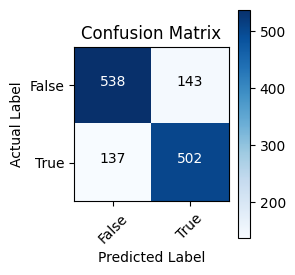

              precision    recall  f1-score   support

         0.0       0.80      0.79      0.79       681
         1.0       0.78      0.79      0.78       639

    accuracy                           0.79      1320
   macro avg       0.79      0.79      0.79      1320
weighted avg       0.79      0.79      0.79      1320



In [32]:
draw_confusion_matrix(best_xgb, x_test, y_test, 'xgboost')

##### (2) ROC Curve - XGBoost

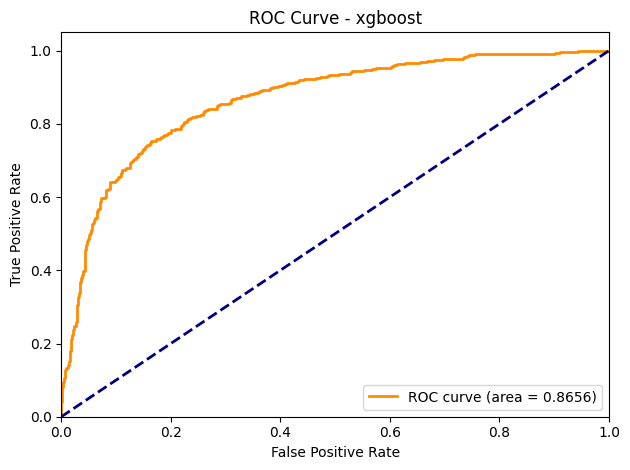

In [33]:
draw_roc(best_xgb, x_test, y_test, 'xgboost')

##### (3) Learning Curve - XGBoost의 분류 오차 추이

In [34]:
# 학습 과정에서 기록된 평가 지표 결과를 딕셔너리 형태로 가져오기
xgb_results = best_xgb.evals_result()

# 총 에포크 수 계산
epochs = len(xgb_results['validation_0']['auc'])

# x축 범위 0부터 epochs까지 (정수)
x_axis = range(0, epochs)

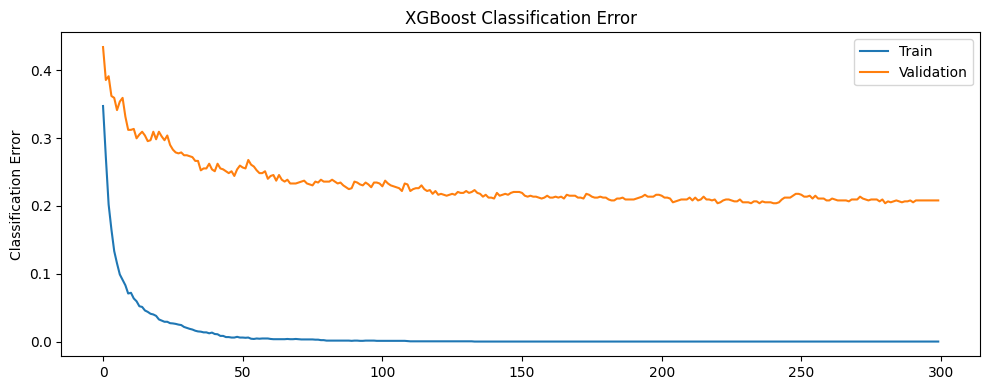

In [35]:
# 학습과 검증 데이터에 대한 분류 오류율을 에포크별로 그려 모델의 학습 과정을 분석
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x_axis, xgb_results['validation_0']['error'], label='Train')
ax.plot(x_axis, xgb_results['validation_1']['error'], label='Validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.tight_layout()
plt.savefig('learning_curve_error_xgb.png', dpi=100, bbox_inches='tight')
plt.show()

- 학습 오류가 검증 오류보다 현저하게 낮다면 이는 좋은 현상이 아닙니다.
  
- 이러한 경우 모델이 과적합되었을 가능성이 높으며, 일반화 성능이 떨어집니다.
  
- 모델의 복잡도를 조절하고, 검증 오류를 지속적으로 모니터링하여 과적합을 방지해야 합니다.

1) 모델 복잡도 줄이기:
max_depth나 n_estimators 등의 하이퍼파라미터를 조정하여 모델의 복잡도를 낮춥니다.
gamma, min_child_weight 등의 규제(regularization) 파라미터를 활용합니다.

2) 더 많은 데이터 수집:
추가 데이터를 확보하여 모델이 더 일반화된 패턴을 학습하도록 합니다.

3) 교차 검증(Cross-Validation):
데이터를 여러 폴드로 나누어 모델의 일반화 성능을 평가하고 과적합을 방지합니다.

4) 조기 종료(Early Stopping):
검증 오류가 감소하지 않거나 증가하기 시작할 때 학습을 멈춥니다.

5) 드롭아웃(Dropout)이나 정규화 기법 사용:
딥러닝 모델의 경우 드롭아웃을 사용하여 과적합을 방지할 수 있습니다.
가중치의 크기를 제한하는 L1 또는 L2 정규화를 적용할 수 있습니다.


##### (4) Learning Curve - XGBoost의 학습 과정 중 AUC 추이

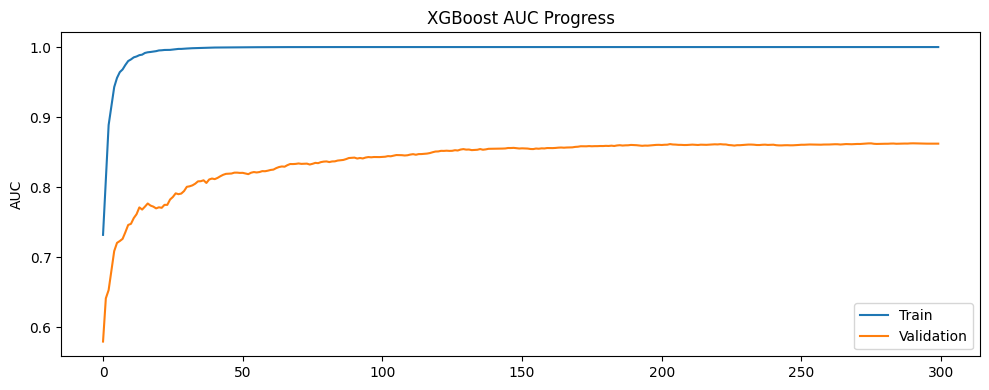

In [36]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x_axis, xgb_results['validation_0']['auc'], label='Train')
ax.plot(x_axis, xgb_results['validation_1']['auc'], label='Validation')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC Progress')
plt.tight_layout()
plt.savefig('learning_curve_auc_xgb.png', dpi=100, bbox_inches='tight')
plt.show()

##### (5) Feature Importance 확인

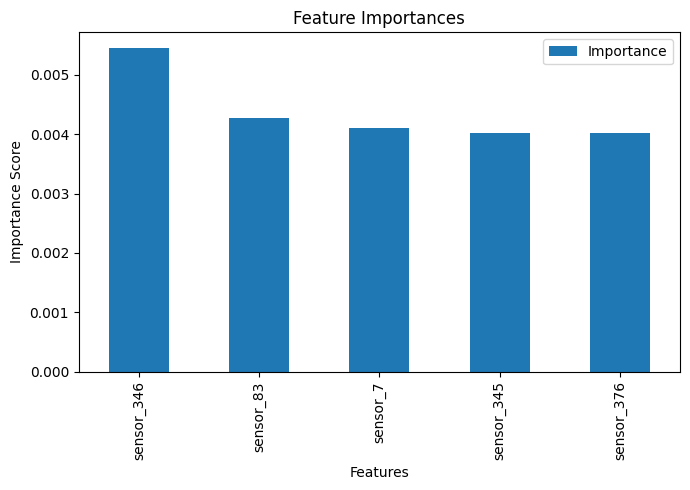

     Features  Importance
3  sensor_346    0.005444
1   sensor_83    0.004274
0    sensor_7    0.004107
2  sensor_345    0.004025
4  sensor_376    0.004015


In [37]:
feat_imp = best_xgb.feature_importances_
important_idx = np.where(feat_imp > 0.004)[0]
important_feats = [f'sensor_{i + 1}' for i in important_idx]
important_imp = feat_imp[important_idx]

res_df = pd.DataFrame({'Features': important_feats, 'Importance': important_imp}).sort_values(by='Importance', ascending=False)
res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances', figsize=(7, 5))
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png', dpi=100, bbox_inches='tight')
plt.show()

print(res_df)